In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math


In [2]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

## get data 

In [240]:
ger_train_path = "/home/adam/play/translate_data/train.de"
eng_train_path = "/home/adam/play/translate_data/train.en"

ger_train_raw = open(ger_train_path, "r").readlines()
eng_train_raw = open(eng_train_path, "r").readlines()

# just to help my poor laptop
ger_train_raw = ger_train_raw[:10000]
eng_train_raw = eng_train_raw[:10000]

In [241]:
print(len(ger_train))
print(len(eng_train))

10000
10000


In [242]:
### tokenize 
tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # do i need to account for the weird #AT things??
tokenizer.train(files=[ger_train_path, eng_train_path,], trainer=trainer)
tokenizer.enable_padding()
# tokenizer.train_from_iterator(iter(ger_train + eng_train), trainer=trainer)


In [243]:
ger_train = tokenizer.encode_batch(ger_train_raw)
eng_train = tokenizer.encode_batch(eng_train_raw)

In [244]:
ger_train = torch.tensor([t.ids for t in ger_train])
eng_train = torch.tensor([t.ids for t in eng_train])

In [245]:
ger_train.shape

torch.Size([10000, 258])

## define model

In [1006]:
def create_mask(src, targ, pad_token):
    # NOTE: not fully confident in the unsqueeze - i think we get the extra-dimension so the masked_fill can broadcast it 
    # we want to broadcast for the padding mask because it's the same on both axes (unlike with the causal mask) 
    src_pad_mask = (src != pad_token).unsqueeze(1).unsqueeze(1) # (B, 1, 1, context_size)
    full_mask = torch.ones((targ.shape[1], targ.shape[1])).type(torch.int).unsqueeze(0).unsqueeze(0) # (1, 1, targ.shape[-1], targ.shape[-1])
    causal_atten_mask = torch.tril(full_mask) # (1, 1, context_size, context_size)
    
    return src_pad_mask, causal_atten_mask

def calculate_loss(logits, labels, pad_idx):
    B, T, V = logits.shape # (batch, context_size, vocab_size)
    # cross entropy expects list of indices and logits requiring reshape
    return F.cross_entropy(logits.reshape(B * T, V), labels.reshape(B * T), ignore_index=pad_idx)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.n_embed = n_embed
        self.n_heads = n_heads
        assert(n_embed % n_heads == 0) # check dims work
        self.head_size = n_embed // n_heads
        self.dropout = dropout

        self.wk = nn.Linear(n_embed, n_embed, bias=False)
        self.wq = nn.Linear(n_embed, n_embed, bias=False)
        self.wv = nn.Linear(n_embed, n_embed, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(n_embed, n_embed)
        self.attn_store = None

    def forward(self, x, features, mask):
        B, T, C = features.shape # (batch, context_size, n_embed)

        # create k
        # NOTE: make sure the maths works here
        k = self.wk(features) # (B, context_size, n_embed) @ (n_embed, n_embed) ---> (B, context_size, n_embed)
        # split per head
        k = k.view(B, T, self.n_heads, self.head_size)  # (B, context_size, n_embed) --> (B, context_size, n_heads, head_size)
        # switch context size and n_heads dim so we can batch matmul over B and n_heads
        k = k.transpose(1,2) # (B, context_size, n_heads, head_size) --> (B, n_heads, context_size, head_size)
        
        # create q 
        q = self.wq(x)
        q = q.view(q.shape[0], q.shape[1], self.n_heads, self.head_size) # q can be a different size to k and v so need to use its own .shape
        q = q.transpose(1,2)

        # create v 
        v = self.wv(features)
        v = v.view(B, T, self.n_heads, self.head_size)
        v = v.transpose(1, 2)

        attn = q @ k.transpose(-2, -1) # (B, n_heads, context_size, head_size) @ (B, n_heads, head_size, context_size) --> (B, n_heads, context_size, context_size)
        attn = attn / (q.shape[-1] ** 0.5) # divide by squareroot of n_embed to decrease magnitude
        
        # if this is a masked attention layer (causal?) mask out all tokens before the cur pos, otherwise just mask out padding 
        attn = attn.masked_fill(mask == 0, float("-inf")) # TODO: check that the dimensions here work
        self.attn_store = attn
        attn = self.dropout(F.softmax(attn, dim=-1))
        
        # generate the v matrix and use the attn matrix to pluck out relevant info on a per head basis
        out = attn @ v # (B, n_heads, context_size, context_size) @ (B, n_heads, context_size, head_size) --> (B, n_heads, context_size, head_size)
        
        # remove per-head dimension and use final linear projection
        out = out.transpose(1,2).contiguous()
        out = out.view(out.shape[0], -1, self.n_embed) # (B, context_size , n_head, head_size) --> (B, context_size, n_embed)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed, dropout):
        super().__init__()
        self.ffw = nn.Sequential(
            nn.Linear(n_embed, 4* n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ffw(x) # (B, context_size, n_embed) @ (n_embed, 4*n_embed) @ (4*n_embed, n_embed) --> (B, context_size, n_embed)

class EncoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, inputs):
        x, mask = inputs
        out = self.ln1(self.attention(x, x, mask)) + x
        out = self.ln2(self.ffw(out)) + out
        return (out, mask)

class DecoderBlock(nn.Module):
    def __init__(self, n_heads, n_embed, dropout):
        super().__init__()
        self.masked_attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.cross_attention = MultiHeadAttention(n_heads, n_embed, dropout)
        self.ffw = FeedForward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

    def forward(self, inputs):
        y, features, src_mask, targ_mask = inputs
        out = self.ln1(self.masked_attention(y, y, targ_mask)) + y
        out = self.ln2(self.cross_attention(out, features, src_mask)) + out
        out = self.ln3(self.ffw(out)) + out
        return (out, features, src_mask, targ_mask)

class PositionalEmbedding(nn.Module):
    def __init__(self, n_embed, context_size):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        posem = torch.zeros((context_size+1, n_embed))
        for pos in range(context_size+1):
            for i in range(0, n_embed, 2):
                posem[pos, i] = math.sin(pos/(10000**(2*i/n_embed)))
                posem[pos, i+1] = math.cos(pos/(10000**(2*(i+1)/n_embed)))
        posem.unsqueeze(0)
        self.register_buffer("posem", posem)

    def forward(self, x):
        return x + self.posem[torch.arange(x.shape[1]),:]

class Generator(nn.Module):
    def __init__(self, n_embed, output_vocab_size):
        super().__init__()
        self.proj = nn.Linear(n_embed, output_vocab_size)

    def forward(self, x):
        return self.proj(x)

class EncoderDecoderTransformer(nn.Module):
    def __init__(self, n_heads, n_embed, dropout, n_blocks, context_size, input_vocab_size, output_vocab_size):
        super().__init__()
        self.input_embedding = nn.Embedding(input_vocab_size, n_embed)
        self.positional_embedding = PositionalEmbedding(n_embed, context_size)
        # self.positional_embedding = PositionalEncoding(n_embed, dropout, context_size)
        self.encoders = nn.Sequential(*[EncoderBlock(n_heads, n_embed, dropout) for _ in range(n_blocks)])
        self.decoders = nn.Sequential(*[DecoderBlock(n_heads, n_embed, dropout) for _ in range(n_blocks)])
        # decoder_block = nn.TransformerDecoderLayer(d_model=n_embed, nhead=n_heads, batch_first=True)
        # self.decoders = nn.TransformerDecoder(decoder_block, num_layers=n_blocks)
        self.output = Generator(n_embed, output_vocab_size)
    
    def encode(self, src, src_mask):
        x = self.input_embedding(src)
        x = self.positional_embedding(x)
        x = self.encoders((x, src_mask))[0]
        return x

    def decode(self, targ, features, src_mask, targ_mask):
        targ = self.input_embedding(targ)
        targ = self.positional_embedding(targ)
        # print(x.shape, features.shape)
        out = self.decoders((targ , features, src_mask, targ_mask))[0]
        
        return self.output(out)
    
    def forward(self, src, targ, src_mask, targ_mask):
        x = self.encode(src, src_mask)
        out = self.decode(targ, x, src_mask, targ_mask)
        return out

# very scratch test forward pass

In [836]:
# TODO: work out how to handle extracting k and v from multiple heads in final encoder block?? very possibly I should just rewrite in the kombo-head pattern 

model = EncoderDecoderTransformer(
    n_heads=3, n_embed=6, dropout=0.2, n_blocks=5, context_size=12, input_vocab_size=13, output_vocab_size=13
)

# x = torch.arange(11)
# y = torch.tensor([[0]])
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
# target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
#                        [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

target = torch.tensor([[0, 1, 3, 4], [0, 3, 4, 4]])
start_symbol = torch.zeros(target.shape[0], 1).fill_(11).type_as(target)
y = torch.cat((start_symbol, target[:,:-1]), dim=1)
src_mask, targ_mask = create_mask(src, target, 99)
out = model(src, y, src_mask, targ_mask)
print(out.shape)
# print(src.shape, src_mask.shape, targ_mask.shape)
# print(targ_mask)

# print(targ_mask)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00],
        [ 8.4147e-01,  9.9892e-01,  2.1544e-03,  1.0000e+00,  4.6416e-06,
          1.0000e+00],
        [ 9.0930e-01,  9.9569e-01,  4.3089e-03,  1.0000e+00,  9.2832e-06,
          1.0000e+00],
        [ 1.4112e-01,  9.9032e-01,  6.4633e-03,  1.0000e+00,  1.3925e-05,
          1.0000e+00],
        [-7.5680e-01,  9.8281e-01,  8.6176e-03,  1.0000e+00,  1.8566e-05,
          1.0000e+00],
        [-9.5892e-01,  9.7319e-01,  1.0772e-02,  1.0000e+00,  2.3208e-05,
          1.0000e+00],
        [-2.7942e-01,  9.6147e-01,  1.2926e-02,  1.0000e+00,  2.7850e-05,
          1.0000e+00],
        [ 6.5699e-01,  9.4768e-01,  1.5080e-02,  1.0000e+00,  3.2491e-05,
          1.0000e+00],
        [ 9.8936e-01,  9.3185e-01,  1.7235e-02,  1.0000e+00,  3.7133e-05,
          1.0000e+00],
        [ 4.1212e-01,  9.1401e-01,  1.9389e-02,  1.0000e+00,  4.1774e-05,
          1.0000e+00],
        [-5.4402e-01,  8.9420e

In [706]:
out.shape

torch.Size([2, 4, 13])

# test on synthetic data

In [901]:
def generate_fake_data(vocab_size, batch_size):
    data = torch.randint(2, vocab_size+2, size=(batch_size, 10))
    src = data.requires_grad_(False).clone().detach()
    target = data.requires_grad_(False).clone().detach()
    target = torch.cat((torch.zeros(target.shape[0], 1), target), dim=1)
    target = torch.cat((target, torch.ones(target.shape[0], 1)), dim=1)
    targ = target[:,:-1].type(torch.long)
    labels = target[:,1:].type(torch.long)
    src_mask, targ_mask = create_mask(src, targ, 99)
    return [src, targ, labels, src_mask, targ_mask]

In [902]:
src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 80)

In [903]:
print(src.shape, targ.shape, labels.shape)
print(targ_mask[0])
print(targ_mask.shape)


torch.Size([80, 10]) torch.Size([80, 11]) torch.Size([80, 11])
tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int32)
torch.Size([1, 1, 11, 11])


In [942]:
## create model
model = EncoderDecoderTransformer(
    n_heads=4, n_embed=32, dropout=0.1, n_blocks=2, context_size=20, input_vocab_size=12, output_vocab_size=12
)

In [1048]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:,:x.shape[1],:]
        return self.dropout(x)

class TestModel(nn.Module):
    def __init__(self, d_model, n_heads, n_block, dropout, input_vocab_size, output_vocab_size, context_size):
        super().__init__()
        self.model = nn.Transformer(
            d_model=d_model, nhead=n_heads, num_encoder_layers=n_block, num_decoder_layers=n_block, dim_feedforward=d_model*4, batch_first=True, dropout=dropout
        )
        
        self.emb = nn.Embedding(input_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, 0.1, context_size)
        self.proj = nn.Linear(d_model, output_vocab_size)

    def forward(self, src, targ):
        src = self.pos_encoder(self.emb(src))
        targ = self.pos_encoder(self.emb(targ))
        out = self.model(src=src, tgt=targ, tgt_mask=nn.Transformer.generate_square_subsequent_mask(src.shape[1]), tgt_is_causal=True)
        return self.proj(out)

# model = TestModel()

In [943]:
## train model

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

losses = []

for step in range(2000):
    src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 80)
    # forward pass
    logits = model(src, targ, src_mask, targ_mask)
    # logits = model(src, targ)

    # print(logits.shape, labels.shape)
    loss = calculate_loss(logits, labels, 99)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optim.step()
    if step % 100 == 0:
        print(f"{step=} {loss.item()=}")

step=0 loss.item()=3.0782485008239746
step=100 loss.item()=1.5178436040878296
step=200 loss.item()=0.9287382364273071
step=300 loss.item()=0.28001466393470764
step=400 loss.item()=0.07486676424741745
step=500 loss.item()=0.048783134669065475
step=600 loss.item()=0.018520882353186607
step=700 loss.item()=0.025122443214058876
step=800 loss.item()=0.0432889498770237
step=900 loss.item()=0.02111428789794445
step=1000 loss.item()=0.008165615610778332
step=1100 loss.item()=0.009171709418296814
step=1200 loss.item()=0.01689954847097397
step=1300 loss.item()=0.026525046676397324
step=1400 loss.item()=0.002337818965315819
step=1500 loss.item()=0.017591223120689392
step=1600 loss.item()=0.0028570888098329306
step=1700 loss.item()=0.020785031840205193
step=1800 loss.item()=0.0007740518194623291
step=1900 loss.item()=0.014752286486327648


In [944]:
print(f"{labels[12].shape=}, {logits[12].shape=}")
print(f"{labels[12]=}")
print(f"{src[12]=}")
print(f"{targ[12]=}")
print(f"{torch.argmax(logits[12], dim=1)=}")
print(logits[12])
# plt.imshow(model.encoders[-1].attention.attn_store[0,3].detach().numpy())


labels[12].shape=torch.Size([11]), logits[12].shape=torch.Size([11, 12])
labels[12]=tensor([10,  9,  7, 11,  7,  6,  3,  9,  4,  8,  1])
src[12]=tensor([10,  9,  7, 11,  7,  6,  3,  9,  4,  8])
targ[12]=tensor([ 0, 10,  9,  7, 11,  7,  6,  3,  9,  4,  8])
torch.argmax(logits[12], dim=1)=tensor([10,  9,  7, 11,  7,  6,  3,  9,  4,  8,  1])
tensor([[-13.0563,  -0.1346,  -1.6679,  -2.3136,  -1.2495,   0.0488,  -3.8849,
          -0.5146,  -1.5872,   0.8989,  11.4112,   0.8164],
        [-11.0475, -13.7259,  -2.5244,  -0.1804,   2.2375,  -1.4239,  -0.4979,
           3.0238,  -1.2176,  10.4206,  -4.1232,  -1.3258],
        [-11.5117, -18.2371,   0.1156,  -1.4028,   1.3638,  -1.1112,  -0.5050,
          10.7667,  -0.6929,  -2.7019,  -1.2392,   0.3604],
        [-11.4407, -15.9157,   0.7418,  -0.1549,  -2.2739,  -1.1314,  -1.7067,
           0.1774,  -0.5108,   0.1951,   1.0337,  11.7634],
        [-11.2095, -11.0170,  -0.8210,  -0.0513,  -3.3414,  -0.2282,  -1.4815,
          11.7649,  -1.0

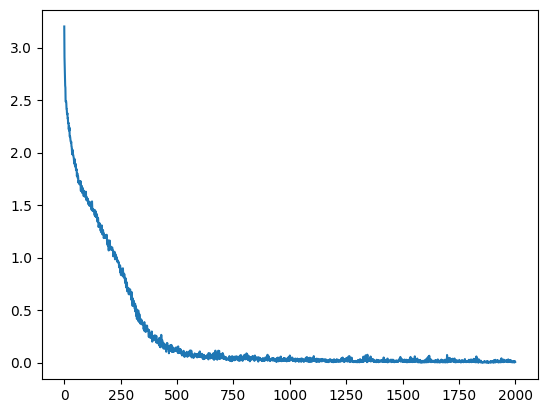

In [907]:
plt.plot(losses)

In [998]:
def greedy_decoding(model, src, context_size):
    # targ = torch.zeros(1,context_size + 1).type(torch.int)
    # targ = torch.zeros(1,src.shape[1] + 1).type(torch.int)
    cur_targ = torch.tensor([[0]])
    src_mask, _ = create_mask(src, src, 99)
    features = model.encode(src, src_mask)
    print(features.shape)
    for i in range(context_size):
        src_mask, targ_mask = create_mask(src, cur_targ, 99)
        proj = model.decode(cur_targ, features, src_mask, targ_mask)
        tok = torch.argmax(proj[0,-1,:], keepdims=True)
        # print(tok.shape)
        tok = tok.unsqueeze(0)
        if tok.item() == 1:
            return cur_targ[:,1:], proj
        cur_targ = torch.cat([cur_targ, tok], dim=1).type(torch.int)
        # targ[0, i+1] = tok
    return cur_targ, proj

cur_src = torch.randint(2, 12, size=(1, 10))
print(cur_src.shape)

cur_targ, proj = greedy_decoding(model, cur_src, 20)
print(cur_src)
print(cur_targ)
assert torch.equal(cur_src, cur_targ)
# print(proj)

torch.Size([1, 10])
torch.Size([1, 10, 32])
tensor([[ 4,  3,  5,  6, 11,  6,  5,  6,  5, 10]])
tensor([[ 4,  3,  5,  6, 11,  6,  5,  6,  5, 10]], dtype=torch.int32)


In [858]:
# ans = torch.max(proj[0,0],0)
# ans
torch.zeros((1,1)).type(torch.int)

tensor([[0]], dtype=torch.int32)

# test training on real data

In [1086]:
import torchtext.datasets
from torch.utils.data import DataLoader

train_data = torchtext.datasets.Multi30k(split='train', language_pair=('de', 'en'))
val_data = torchtext.datasets.Multi30k(split='valid', language_pair=('de', 'en'))

In [1087]:
import en_core_web_sm
import de_core_news_sm

en_tokenizer = en_core_web_sm.load()
de_tokenizer = de_core_news_sm.load()

In [1091]:
train_data.urls

AttributeError: 'ShardingFilterIterDataPipe' object has no attribute 'urls

In [1001]:
from collections import Counter

def get_unique_tokens(text, tokenizer):
    cnt = Counter()
    for doc in tokenizer.pipe(text):
        doc_tokens = [tok.text.strip() for tok in doc if len(tok.text) > 0]
        cnt.update(doc_tokens)
    return [tok[0] for tok in cnt.most_common(10000)]

src_text, targ_text = list(zip(*train_data))

de_toks = get_unique_tokens(src_text, de_tokenizer)
en_toks = get_unique_tokens(targ_text, en_tokenizer)


In [1026]:
# special token indices
UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

UNK = '<unk>' # Unknown
PAD = '<pad>' # Padding
SOS = '<sos>' # Start of sentence
EOS = '<eos>' # End of sentence

SPECIAL_TOKENS = [UNK, PAD, SOS, EOS]

class Vocab:
    def __init__(self, tokenizer, tokens):
        self.tokenizer = tokenizer
        self.tokens = SPECIAL_TOKENS + tokens
        self.token_idxs = {self.tokens[i]: i for i in range(len(tokens))}

    def __call__(self, text):
        return [self.numerify(tok.text.strip()) for tok in self.tokenizer(text)]
    
    def numerify(self, tok):
        if tok not in self.token_idxs:
            return UNK_IDX
        return self.token_idxs[tok]

    def textify(self, idx):
        return tokens[idx]

de_vocab = Vocab(de_tokenizer, de_toks)
en_vocab = Vocab(en_tokenizer, en_toks)

In [1003]:
from torch.nn.utils.rnn import pad_sequence

def make_dataloader(dataset, batch_size, context_size, device): 
    def collate_fn(batch):
        srcs = []
        targs = []
        for i, (src_sentence, targ_sentence) in enumerate(batch):
            src = de_vocab(src_sentence)
            targ = [SOS_IDX] + en_vocab(targ_sentence) + [EOS_IDX]
    
            srcs.append(torch.tensor(src))
            targs.append(torch.tensor(targ))
    
        src_batch = pad_sequence(srcs, padding_value=PAD_IDX, batch_first=True)
        targ_batch = pad_sequence(targs, padding_value=PAD_IDX, batch_first=True)
    
        # decoder wants target starting with SOS
        target_batch = targ_batch[:, :-1]
        # however when calculating loss we are only interested in tokens after SOS and ending with EOS
        label_batch = targ_batch[:, 1:]
        src_mask, targ_mask = create_mask(src_batch, target_batch, PAD_IDX) # TODO: understand what the hell happens with different context lengths
    
        all_batches = [src_batch, target_batch, label_batch, src_mask, targ_mask]
        return [b.to(device) for b in all_batches]

    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

# train_dataloader = make_dataloader(train_data, 32, 40, "cpu")
val_dataloader = make_dataloader(val_data, 100, 40, "cpu")

In [1085]:
from tqdm import tqdm

model = EncoderDecoderTransformer(
    n_heads=8, n_embed=128, dropout=0.2, n_blocks=6, context_size=44, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens)
)

# model = TestModel(d_model=128, n_heads=8, n_block=6, dropout=0.2, input_vocab_size=len(de_vocab.tokens), output_vocab_size=len(en_vocab.tokens), context_size=44)

optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

for epoch in range(3):
    losses = []
    train_dataloader = make_dataloader(train_data, 32, 40, "cpu")
    # with tqdm(train_dataloader, unit="batch") as batch_iter:
    for step, (src, targ, labels, src_mask, targ_mask) in enumerate(train_dataloader):
        # forward pass
        logits = model(src, targ, src_mask, targ_mask)

        # logits = model(src, targ)
        loss = calculate_loss(logits, labels, PAD_IDX)
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        if step % 10 == 0:
            print(f"{epoch=} {step=} {loss.item()=}")
    

epoch=0 step=0 loss.item()=12.463160514831543
epoch=0 step=10 loss.item()=6.699718475341797
epoch=0 step=20 loss.item()=5.784508228302002
epoch=0 step=30 loss.item()=5.522207260131836
epoch=0 step=40 loss.item()=5.704879283905029
epoch=0 step=50 loss.item()=5.745138645172119
epoch=0 step=60 loss.item()=5.3376545906066895
epoch=0 step=70 loss.item()=5.151719570159912
epoch=0 step=80 loss.item()=5.013647556304932
epoch=0 step=90 loss.item()=4.826727390289307
epoch=0 step=100 loss.item()=5.090468883514404
epoch=0 step=110 loss.item()=4.916821002960205
epoch=0 step=120 loss.item()=4.664466857910156
epoch=0 step=130 loss.item()=4.7534308433532715
epoch=0 step=140 loss.item()=4.265157699584961
epoch=0 step=150 loss.item()=4.199601173400879
epoch=0 step=160 loss.item()=5.579021453857422
epoch=0 step=170 loss.item()=4.554587364196777
epoch=0 step=180 loss.item()=4.419059753417969
epoch=0 step=190 loss.item()=4.6456427574157715
epoch=0 step=200 loss.item()=4.274139404296875
epoch=0 step=210 los

KeyboardInterrupt: 

In [1084]:
losses

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

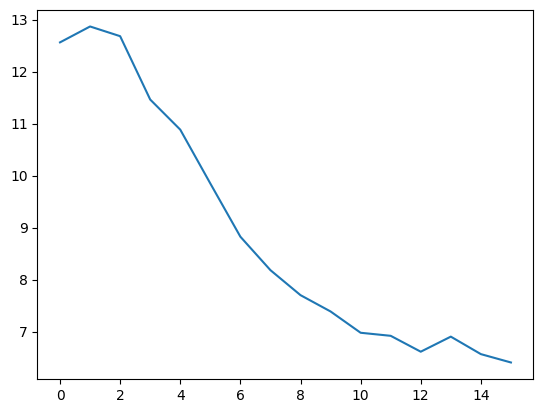

In [1073]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [1056]:
def greedy_decoding(model, src, context_size):
    cur_targ = torch.tensor([[SOS_IDX]])
    src_mask, _ = create_mask(src, src, PAD_IDX)
    features = model.encode(src, src_mask)
    for i in range(context_size):
        src_mask, targ_mask = create_mask(src, cur_targ, PAD_IDX)
        proj = model.decode(cur_targ, features, src_mask, targ_mask)
        tok = torch.argmax(proj[0,-1,:], keepdims=True)
        tok = tok.unsqueeze(0)

        if tok.item() == EOS_IDX:
            return cur_targ[:,1:]
        cur_targ = torch.cat([cur_targ, tok], dim=1).type(torch.int)
    return cur_targ


cur_src = next(val_dataloader.__iter__())[0][0]
print(cur_src.shape)

cur_targ = greedy_decoding(model, src, 44)
print(f"{cur_src.shape=} {cur_targ.shape=}")
print(cur_src)
print(cur_targ)

torch.Size([33])


AttributeError: 'TestModel' object has no attribute 'encode'

## prove i'm not going mad

In [430]:
mad_model = nn.Sequential(*[
    nn.Embedding(12, 64),
    nn.Linear(64, 64), 
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 12),
])

In [442]:
## train model

optim = torch.optim.Adam(mad_model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

mad_losses = []

for step in range(5000):
    src, targ, labels, src_mask, targ_mask = generate_fake_data(10, 64)
    # forward pass
    logits = mad_model(targ)
    loss = calculate_loss(logits, labels, 99)
    mad_losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 100 == 0:
        print(f"{step=} {loss.item()=}")

step=0 loss.item()=2.388169765472412
step=100 loss.item()=2.3888556957244873
step=200 loss.item()=2.388322114944458
step=300 loss.item()=2.389343500137329
step=400 loss.item()=2.3888862133026123
step=500 loss.item()=2.389543294906616
step=600 loss.item()=2.389639139175415
step=700 loss.item()=2.3891899585723877
step=800 loss.item()=2.3885772228240967
step=900 loss.item()=2.3891406059265137
step=1000 loss.item()=2.3889760971069336
step=1100 loss.item()=2.3888492584228516
step=1200 loss.item()=2.388840913772583
step=1300 loss.item()=2.3880326747894287
step=1400 loss.item()=2.3901073932647705
step=1500 loss.item()=2.388791799545288
step=1600 loss.item()=2.388441324234009
step=1700 loss.item()=2.388833522796631
step=1800 loss.item()=2.388218641281128
step=1900 loss.item()=2.389049530029297
step=2000 loss.item()=2.388721227645874
step=2100 loss.item()=2.389326333999634
step=2200 loss.item()=2.389786720275879
step=2300 loss.item()=2.3887150287628174
step=2400 loss.item()=2.3884451389312744
s

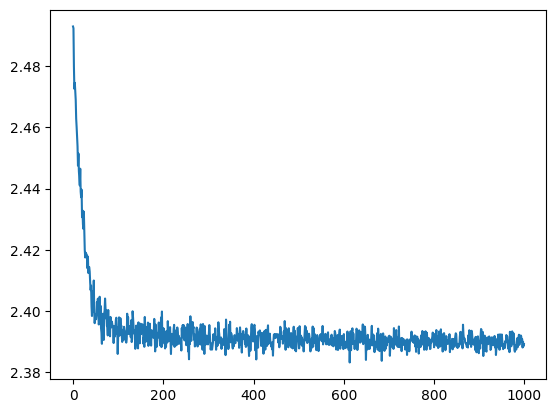

In [434]:
plt.plot(mad_losses)

In [443]:
print(labels[3].shape, logits[3].shape)
print(labels[3])
# print(logits[3])
print(torch.argmax(logits[3], dim=1))
# plt.imshow(model.decoders[-3].masked_attention.attn_store[0,3].detach().numpy())
print(src[3])
print(logits[3])

torch.Size([11]) torch.Size([11, 12])
tensor([ 7, 11, 10,  5,  7,  7,  7,  4,  2,  2,  1])
tensor([9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([ 7, 11, 10,  5,  7,  7,  7,  4,  2,  2])
tensor([[-1.5438e+01, -8.4221e+00, -5.0352e-03,  8.0487e-03,  1.3012e-03,
          1.4250e-02,  8.1259e-03,  3.2770e-02, -9.2824e-03,  6.3673e-02,
          6.0511e-03,  4.4197e-03],
        [-1.1735e+01,  1.2412e-01,  1.5581e-02,  1.7600e-02,  2.0030e-02,
          1.9316e-02,  1.1991e-02,  2.8883e-02, -3.1396e-03,  4.1399e-02,
          1.6999e-02,  2.2419e-02],
        [-1.1735e+01,  1.2412e-01,  1.5581e-02,  1.7600e-02,  2.0030e-02,
          1.9316e-02,  1.1991e-02,  2.8883e-02, -3.1396e-03,  4.1399e-02,
          1.6999e-02,  2.2419e-02],
        [-1.1735e+01,  1.2412e-01,  1.5581e-02,  1.7600e-02,  2.0030e-02,
          1.9316e-02,  1.1991e-02,  2.8883e-02, -3.1396e-03,  4.1399e-02,
          1.6999e-02,  2.2419e-02],
        [-1.1735e+01,  1.2412e-01,  1.5581e-02,  1.7600e-02,  2.0030e-02,
        